In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing

## Path and param

In [ ]:
from pathlib import Path
data_path = Path('/content/drive/MyDrive/FacialAge/Data_linear')
width = height = 224
img_size = (width, height)
img_shape = img_size + (3, )
batch_size = 32 
initial_epochs = 25
fine_tune_epochs = 25
seed = 10
learning_rate = 1e-4
results = {}

## Predict Groups Class

In [ ]:
groups_names= ['Children', 'Teenage', 'Youth', 'Middle', 'Old']
def predict_class(age):
  if age <= 10: return groups_names[0] #Children 0 - 10
  if age <= 18: return groups_names[1] #Teenage 10 - 18
  if age <= 34: return groups_names[2] #Youth   19 - 34
  if age <= 60: return groups_names[3] #Middle  35 - 60
  return groups_names[4]               #Old     61+

## Load data
70% train, 15% test, 15% val

### Train Dataset

In [ ]:
from tensorflow.data.experimental import cardinality
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
                                      data_path,
                                      seed=seed,
                                      image_size=img_size,
                                      smart_resize=True,
                                      batch_size=batch_size)
train_batches = cardinality(train_ds)

Found 9778 files belonging to 99 classes.


## Data# Visualization

In [ ]:
class_names = train_ds.class_names
num_class = len(class_names)
print(num_class,' - ',class_names)

99  -  ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110']


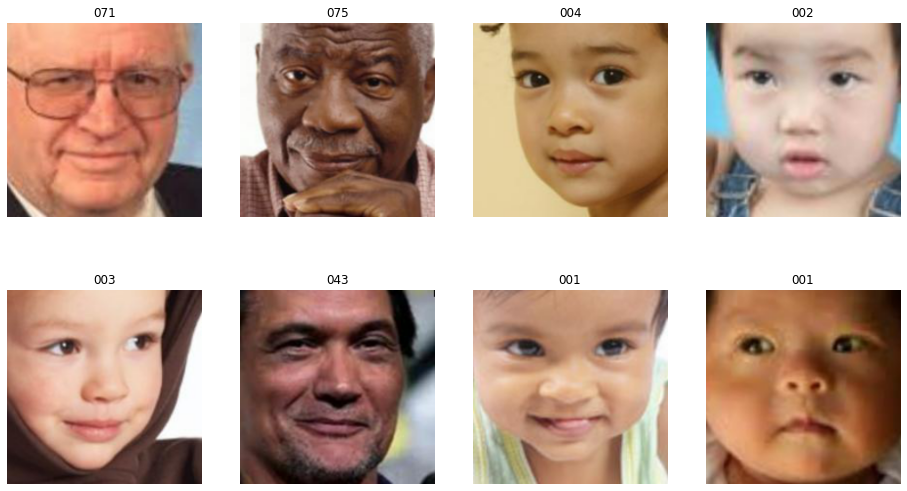

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
images, labels = next(iter(train_ds))
for i in range(8):
  ax = plt.subplot(2, 4, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(train_ds.class_names[labels[i]])
  plt.axis("off")

### Test Dataset

In [ ]:
test_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

### Val Dataset

In [ ]:
val_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

## Data Performance

In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# PreTrain

## Call Back 

In [ ]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=1, # if val_loss plateaus for 1 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

## Data augment

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape = img_shape),
    RandomRotation(0.1),
    RandomZoom(-0.1,0.1),
  ]
)

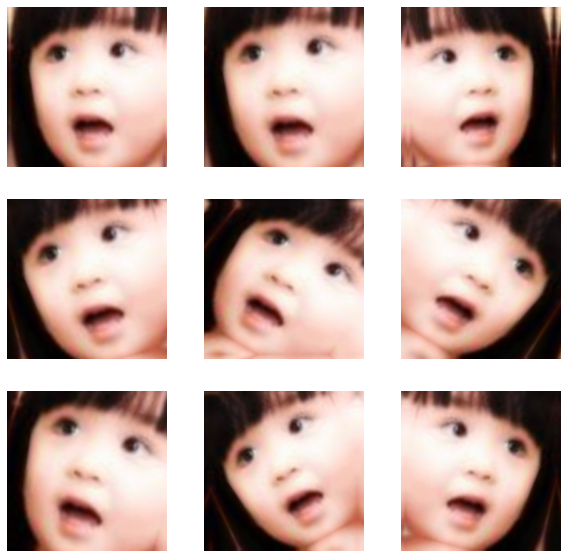

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Build Model

## MobileNet V1

### Add new layers

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

# download model MobileNet V1
base_model_v1 = MobileNet(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_v1.trainable = False

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_v1(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)  
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_v1 = Model(inputs, outputs)
model_v1.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0     

In [ ]:
model_v1_history = model_v1.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/25
216/216 [==============================] - 913s 4s/step - loss: 20.5782 - mean_absolute_error: 20.5782 - val_loss: 18.3047 - val_mean_absolute_error: 18.3047
Epoch 2/25
216/216 [==============================] - 9s 44ms/step - loss: 16.4151 - mean_absolute_error: 16.4151 - val_loss: 15.4246 - val_mean_absolute_error: 15.4246
Epoch 3/25
216/216 [==============================] - 9s 43ms/step - loss: 14.6015 - mean_absolute_error: 14.6015 - val_loss: 14.1264 - val_mean_absolute_error: 14.1264
Epoch 4/25
216/216 [==============================] - 9s 44ms/step - loss: 13.5309 - mean_absolute_error: 13.5309 - val_loss: 13.1793 - val_mean_absolute_error: 13.1793
Epoch 5/25
216/216 [==============================] - 9s 44ms/step - loss: 12.7743 - mean_absolute_error: 12.7743 - val_loss: 12.5436 - val_mean_absolute_error: 12.5436
Epoch 6/25
216/216 [==============================] - 9s 44ms/step - loss: 12.1655 - mean_absolute_error: 12.1655 - val_loss: 12.0115 - val_mean_absolute_e

### Fine tuning

In [ ]:
base_model_v1.trainable = True

In [ ]:
len(base_model_v1.layers)

86

In [ ]:
ft_at = 10
for layer in base_model_v1.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_v1.layers[ft_at:]:
    layer.trainable = True
model_v1.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v1_fn = model_v1.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_v1_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 25/50
216/216 [==============================] - 35s 141ms/step - loss: 10.0978 - mean_absolute_error: 10.0978 - val_loss: 9.4236 - val_mean_absolute_error: 9.4236
Epoch 26/50
216/216 [==============================] - 30s 139ms/step - loss: 7.8229 - mean_absolute_error: 7.8229 - val_loss: 6.5624 - val_mean_absolute_error: 6.5624
Epoch 27/50
216/216 [==============================] - 30s 140ms/step - loss: 7.0932 - mean_absolute_error: 7.0932 - val_loss: 6.5386 - val_mean_absolute_error: 6.5386
Epoch 28/50
216/216 [==============================] - 30s 140ms/step - loss: 6.8111 - mean_absolute_error: 6.8111 - val_loss: 7.0050 - val_mean_absolute_error: 7.0050

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 29/50
216/216 [==============================] - 30s 141ms/step - loss: 5.7617 - mean_absolute_error: 5.7617 - val_loss: 5.5192 - val_mean_absolute_error: 5.5192
Epoch 30/50
216/216 [==============================] - 31s 142ms/step - loss:

In [ ]:
model_v1_train_loss = model_v1_fn.history["loss"]
model_v1_val_loss = model_v1_fn.history["val_loss"]
model_v1_train_acc = model_v1_fn.history["mean_absolute_error"]
model_v1_val_acc = model_v1_fn.history["val_mean_absolute_error"]

results["model_v1"] = {'train-loss': model_v1_train_loss,
                             'val-loss': model_v1_val_loss,
                             'train-mae': model_v1_train_acc,
                             'val-mae': model_v1_val_acc}

## MobileNet V2

### Add new layers

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# download model MobileNet V2
base_model_v2 = MobileNetV2(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_v2.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_v2(x, training=False) 
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)  
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_v2 = Model(inputs, outputs)
model_v2.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0   

In [ ]:
model_v2_history = model_v2.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/25
216/216 [==============================] - 15s 55ms/step - loss: 20.0043 - mean_absolute_error: 20.0043 - val_loss: 17.4186 - val_mean_absolute_error: 17.4186
Epoch 2/25
216/216 [==============================] - 11s 50ms/step - loss: 16.0977 - mean_absolute_error: 16.0977 - val_loss: 15.4715 - val_mean_absolute_error: 15.4715
Epoch 3/25
216/216 [==============================] - 11s 50ms/step - loss: 14.5697 - mean_absolute_error: 14.5697 - val_loss: 14.2730 - val_mean_absolute_error: 14.2730
Epoch 4/25
216/216 [==============================] - 11s 50ms/step - loss: 13.6874 - mean_absolute_error: 13.6874 - val_loss: 13.5318 - val_mean_absolute_error: 13.5318
Epoch 5/25
216/216 [==============================] - 11s 50ms/step - loss: 12.9554 - mean_absolute_error: 12.9554 - val_loss: 12.8935 - val_mean_absolute_error: 12.8935
Epoch 6/25
216/216 [==============================] - 11s 51ms/step - loss: 12.3113 - mean_absolute_error: 12.3113 - val_loss: 12.3683 - val_mean_abso

### Fine tuning

In [ ]:
base_model_v2.trainable = True

In [ ]:
len(base_model_v2.layers)

154

In [ ]:
ft_at = 30
for layer in base_model_v2.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_v2.layers[ft_at:]:
    layer.trainable = True
model_v2.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v2_fn = model_v2.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_v2_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 21/50
216/216 [==============================] - 27s 104ms/step - loss: 11.2546 - mean_absolute_error: 11.2546 - val_loss: 8.0709 - val_mean_absolute_error: 8.0709
Epoch 22/50
216/216 [==============================] - 22s 100ms/step - loss: 8.4007 - mean_absolute_error: 8.4007 - val_loss: 7.7500 - val_mean_absolute_error: 7.7500
Epoch 23/50
216/216 [==============================] - 22s 101ms/step - loss: 7.3649 - mean_absolute_error: 7.3649 - val_loss: 6.9574 - val_mean_absolute_error: 6.9574
Epoch 24/50
216/216 [==============================] - 22s 100ms/step - loss: 7.0556 - mean_absolute_error: 7.0556 - val_loss: 7.2771 - val_mean_absolute_error: 7.2771

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 25/50
216/216 [==============================] - 22s 101ms/step - loss: 6.2124 - mean_absolute_error: 6.2124 - val_loss: 6.1843 - val_mean_absolute_error: 6.1843
Epoch 26/50
216/216 [==============================] - 22s 101ms/step - loss:

In [ ]:
model_v2_train_loss = model_v2_fn.history["loss"]
model_v2_val_loss = model_v2_fn.history["val_loss"]
model_v2_train_acc = model_v2_fn.history["mean_absolute_error"]
model_v2_val_acc = model_v2_fn.history["val_mean_absolute_error"]

results["model_v2"] = {'train-loss': model_v2_train_loss,
                             'val-loss': model_v2_val_loss,
                             'train-mae': model_v2_train_acc,
                             'val-mae': model_v2_val_acc}

## MobileNet V3L

### Add new layers

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3L
base_model_v3L = MobileNetV3Large(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_v3L.trainable = False

17612800/17605208 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_v3L(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_v3L = Model(inputs, outputs)
model_v3L.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v3L.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               327936    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257 

In [ ]:
model_v3L_history = model_v3L.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/25
216/216 [==============================] - 16s 55ms/step - loss: 19.1763 - mean_absolute_error: 19.1763 - val_loss: 16.4347 - val_mean_absolute_error: 16.4347
Epoch 2/25
216/216 [==============================] - 11s 50ms/step - loss: 15.2916 - mean_absolute_error: 15.2916 - val_loss: 14.4471 - val_mean_absolute_error: 14.4471
Epoch 3/25
216/216 [==============================] - 11s 50ms/step - loss: 13.9212 - mean_absolute_error: 13.9212 - val_loss: 13.3804 - val_mean_absolute_error: 13.3804
Epoch 4/25
216/216 [==============================] - 11s 50ms/step - loss: 12.9839 - mean_absolute_error: 12.9839 - val_loss: 12.5906 - val_mean_absolute_error: 12.5906
Epoch 5/25
216/216 [==============================] - 11s 49ms/step - loss: 12.3819 - mean_absolute_error: 12.3819 - val_loss: 11.9252 - val_mean_absolute_error: 11.9252
Epoch 6/25
216/216 [==============================] - 11s 49ms/step - loss: 11.7737 - mean_absolute_error: 11.7737 - val_loss: 11.4878 - val_mean_abso

### Fine tuning

In [ ]:
base_model_v3L.trainable = True

In [ ]:
len(base_model_v3L.layers)

276

In [ ]:
ft_at = 30
for layer in base_model_v3L.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_v3L.layers[ft_at:]:
    layer.trainable = True
model_v3L.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v3L_fn = model_v3L.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_v3L_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 25/50
216/216 [==============================] - 33s 124ms/step - loss: 7.7786 - mean_absolute_error: 7.7786 - val_loss: 6.5951 - val_mean_absolute_error: 6.5951
Epoch 26/50
216/216 [==============================] - 26s 119ms/step - loss: 6.4931 - mean_absolute_error: 6.4931 - val_loss: 5.9394 - val_mean_absolute_error: 5.9394
Epoch 27/50
216/216 [==============================] - 25s 117ms/step - loss: 6.0031 - mean_absolute_error: 6.0031 - val_loss: 5.6684 - val_mean_absolute_error: 5.6684
Epoch 28/50
216/216 [==============================] - 25s 117ms/step - loss: 5.5705 - mean_absolute_error: 5.5705 - val_loss: 5.7158 - val_mean_absolute_error: 5.7158

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 29/50
216/216 [==============================] - 25s 117ms/step - loss: 4.8771 - mean_absolute_error: 4.8771 - val_loss: 5.2971 - val_mean_absolute_error: 5.2971
Epoch 30/50
216/216 [==============================] - 25s 118ms/step - loss: 4

In [ ]:
model_v3L_train_loss = model_v3L_fn.history["loss"]
model_v3L_val_loss = model_v3L_fn.history["val_loss"]
model_v3L_train_acc = model_v3L_fn.history["mean_absolute_error"]
model_v3L_val_acc = model_v3L_fn.history["val_mean_absolute_error"]

results["model_v3L"] = {'train-loss': model_v3L_train_loss,
                             'val-loss': model_v3L_val_loss,
                             'train-mae': model_v3L_train_acc,
                             'val-mae': model_v3L_val_acc}

## MobileNet V3M

### Add new layers

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3S
base_model_v3S = MobileNetV3Small(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_v3S.trainable = False

6701056/6698480 [==============================] - 0s 0us/step


In [ ]:
inputs = Input(shape=img_shape, dtype = tf.uint8)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_v3S(x, training=False)
x = GlobalAveragePooling2D(input_shape=img_shape)(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="tanh")(x)
outputs = Dense(1, activation="linear")(x)

# Final model
model_v3S = Model(inputs, outputs)
model_v3S.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v3S.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257 

In [ ]:
model_v3S_history = model_v3S.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/25
216/216 [==============================] - 10s 32ms/step - loss: 20.0203 - mean_absolute_error: 20.0203 - val_loss: 17.3367 - val_mean_absolute_error: 17.3367
Epoch 2/25
216/216 [==============================] - 6s 27ms/step - loss: 15.9541 - mean_absolute_error: 15.9541 - val_loss: 14.9041 - val_mean_absolute_error: 14.9041
Epoch 3/25
216/216 [==============================] - 6s 27ms/step - loss: 14.4195 - mean_absolute_error: 14.4195 - val_loss: 13.7223 - val_mean_absolute_error: 13.7223
Epoch 4/25
216/216 [==============================] - 6s 27ms/step - loss: 13.3758 - mean_absolute_error: 13.3758 - val_loss: 12.9084 - val_mean_absolute_error: 12.9084
Epoch 5/25
216/216 [==============================] - 6s 27ms/step - loss: 12.6895 - mean_absolute_error: 12.6895 - val_loss: 12.2855 - val_mean_absolute_error: 12.2855
Epoch 6/25
216/216 [==============================] - 6s 27ms/step - loss: 12.1321 - mean_absolute_error: 12.1321 - val_loss: 11.8165 - val_mean_absolute_

### Fine tuning

In [ ]:
base_model_v3S.trainable = True

In [ ]:
len(base_model_v3S.layers)

243

In [ ]:
ft_at = 30
for layer in base_model_v3S.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_v3S.layers[ft_at:]:
    layer.trainable = True
model_v3S.compile(optimizer=Adam(learning_rate = learning_rate),loss="mean_absolute_error",metrics=['mean_absolute_error'])

In [ ]:
model_v3S_fn = model_v3S.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_v3S_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 25/50
216/216 [==============================] - 18s 59ms/step - loss: 8.1986 - mean_absolute_error: 8.1986 - val_loss: 7.1232 - val_mean_absolute_error: 7.1232
Epoch 26/50
216/216 [==============================] - 12s 55ms/step - loss: 7.1796 - mean_absolute_error: 7.1796 - val_loss: 6.5655 - val_mean_absolute_error: 6.5655
Epoch 27/50
216/216 [==============================] - 12s 55ms/step - loss: 6.5560 - mean_absolute_error: 6.5560 - val_loss: 6.6176 - val_mean_absolute_error: 6.6176

Epoch 00027: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 28/50
216/216 [==============================] - 12s 54ms/step - loss: 5.9599 - mean_absolute_error: 5.9599 - val_loss: 6.1378 - val_mean_absolute_error: 6.1378
Epoch 29/50
216/216 [==============================] - 12s 54ms/step - loss: 5.8493 - mean_absolute_error: 5.8493 - val_loss: 6.0918 - val_mean_absolute_error: 6.0918
Epoch 30/50
216/216 [==============================] - 12s 55ms/step - loss: 5.8213 

In [ ]:
model_v3S_train_loss = model_v3S_fn.history["loss"]
model_v3S_val_loss = model_v3S_fn.history["val_loss"]
model_v3S_train_acc = model_v3S_fn.history["mean_absolute_error"]
model_v3S_val_acc = model_v3S_fn.history["val_mean_absolute_error"]

results["model_v3S"] = {'train-loss': model_v3S_train_loss,
                             'val-loss': model_v3S_val_loss,
                             'train-mae': model_v3S_train_acc,
                             'val-mae': model_v3S_val_acc}

# Save Model

In [ ]:
from tensorflow.keras.models import save_model, load_model
model_path = Path('/content/drive/MyDrive/FacialAge/Model_linear')

In [ ]:
save_model (model_v1 , model_path/'MobileNetV1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_linear/MobileNetV1/assets


In [ ]:
save_model (model_v2 , model_path/'MobileNetV2')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_linear/MobileNetV2/assets


In [ ]:
save_model (model_v3L , model_path/'MobileNetV3Large')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_linear/MobileNetV3Large/assets


In [ ]:
save_model (model_v3S , model_path/'MobileNetV3Small')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_linear/MobileNetV3Small/assets


# Visualise

## Model Performances

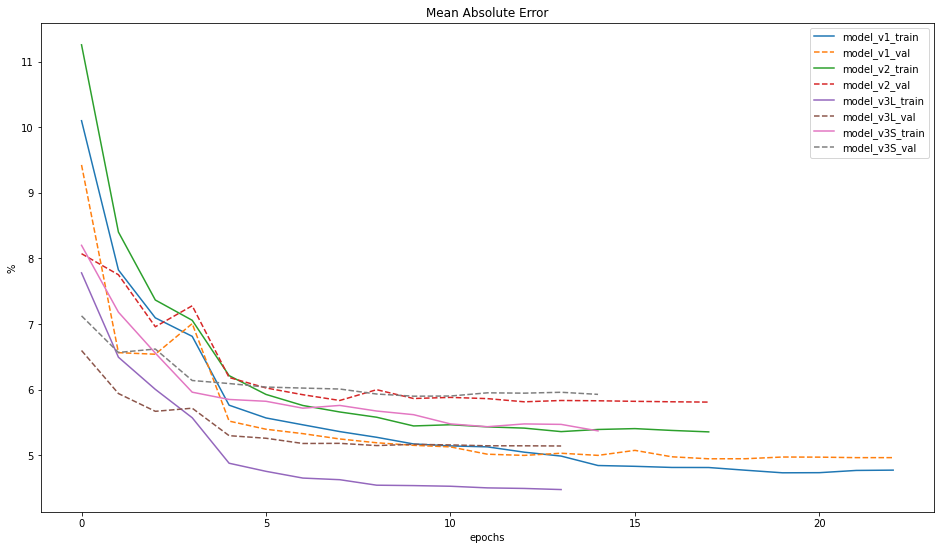

In [ ]:
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(16,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '--', label=cond+"_val")
plt.title("Mean Absolute Error")
plt.xlabel("epochs")
plt.ylabel("%")
plt.legend()
plt.show()

## Evaluate performance on test set

In [ ]:
loss_v1, mae_v1 = model_v1.evaluate(val_ds)

45/45 [==============================] - 5s 106ms/step - loss: 5.0846 - mean_absolute_error: 5.0846


In [ ]:
loss_v2, mae_v2 = model_v2.evaluate(val_ds)

45/45 [==============================] - 2s 41ms/step - loss: 5.6166 - mean_absolute_error: 5.6166


In [ ]:
loss_v3L, mae_v3L = model_v3L.evaluate(val_ds)

45/45 [==============================] - 2s 39ms/step - loss: 5.1576 - mean_absolute_error: 5.1576


In [ ]:
loss_v3S, mae_v3S = model_v3S.evaluate(val_ds)

45/45 [==============================] - 1s 20ms/step - loss: 5.8063 - mean_absolute_error: 5.8063


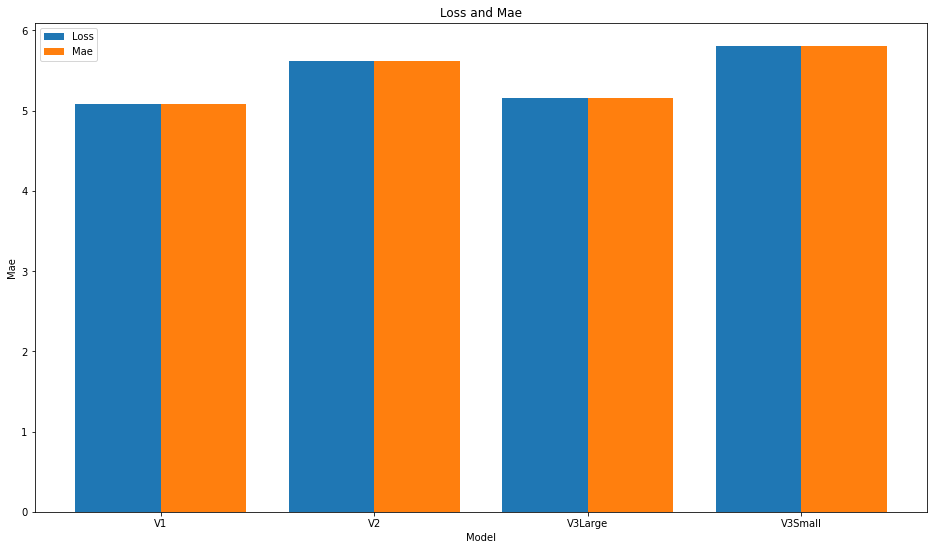

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np

X = ['V1','V2','V3Large','V3Small']
Loss = np.array( [ loss_v1 , loss_v2 , loss_v3L , loss_v3S ] )
Mae = np.array( [ mae_v1 , mae_v2 , mae_v3L , mae_v3S ] )

X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  

plt.bar(X_axis - 0.2, Loss, 0.4, label = 'Loss')
plt.bar(X_axis + 0.2, Mae, 0.4, label = 'Mae')
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Mae")
plt.title("Loss and Mae")
plt.legend()
plt.show()

## Size of Model

In [ ]:
import os
def getsize_model(folder_path):
  size = 0
  for path, dirs, files in os.walk(folder_path):
      for f in files:
          fp = os.path.join(path, f)
          size += os.path.getsize(fp)
  return size

In [ ]:
size_v1 = getsize_model(model_path/'MobileNetV1') 

In [ ]:
size_v2 = getsize_model(model_path/'MobileNetV2') 

In [ ]:
size_v3L = getsize_model(model_path/'MobileNetV3Large') 

In [ ]:
size_v3S = getsize_model(model_path/'MobileNetV3Small') 

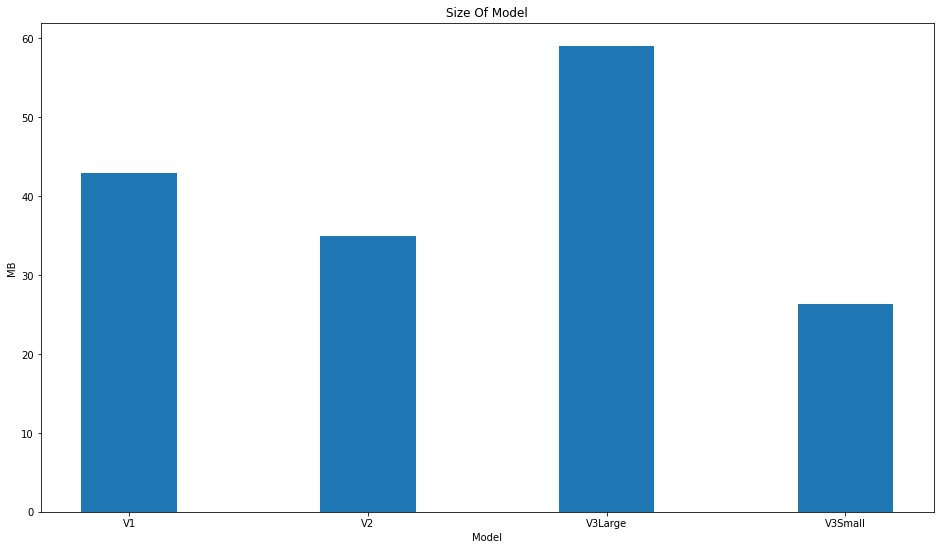

In [ ]:
X = ['V1','V2','V3Large','V3Small']
Y = np.array ( [ size_v1 , size_v2 , size_v3L , size_v3S ] ) / 1024 / 1024
X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  
plt.bar(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MB")
plt.title("Size Of Model")
plt.show()

# API

In [2]:
! pip install flask_cors

In [3]:
!pip install flask-ngrok

In [4]:
!pip install DeepFace

     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 2.3MB 31.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=19699043890e14a05e3e65c7c5aed542657397e060aafb3e0fa1cae94f3009b4
  Stored in directory: /root/.cache/pip/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


## Load Model

In [22]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from deepface import DeepFace
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
model_path = Path('/content/drive/MyDrive/FacialAge/Model_linear')

In [7]:
model = load_model(model_path/'MobileNetV3Large')

## Predict Groups Class

In [8]:
groups_names= ['Children', 'Teenage', 'Youth', 'Middle', 'Old']
def predict_class(age):
  if age <= 10: return groups_names[0] #Children 0 - 10
  if age <= 18: return groups_names[1] #Teenage 10 - 18
  if age <= 34: return groups_names[2] #Youth   19 - 34
  if age <= 60: return groups_names[3] #Middle  35 - 60
  return groups_names[4]               #Old     61+

## Preprocess Input

In [9]:
def preprocess_image(data):
    image = Image.fromarray(data, 'RGB')
    image = image.resize((224,224))
    image = np.array(image)
    image = np.expand_dims(image, axis = 0)
    return image

## Detect Face

In [10]:
def detect_face(img_path):
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']
    detected_face = DeepFace.detectFace( img_path , detector_backend=backends[2])
    return detected_face

## Predict Age

In [11]:
def predict_age(image):
    input = preprocess_image(image)
    result = model.predict(input)
    return int(result), predict_class(result)

## Result

In [37]:
test_path = '/content/drive/MyDrive/FacialAge/image.jpg'
detected_face = detect_face(test_path)
input = preprocess_image(detected_face)
age = model.predict(input)
text = 'Age: '+ str(int(age)) + ' - '+ str(predict_class(age))

Text(0.5, 1.0, 'Age: 23 - Youth')

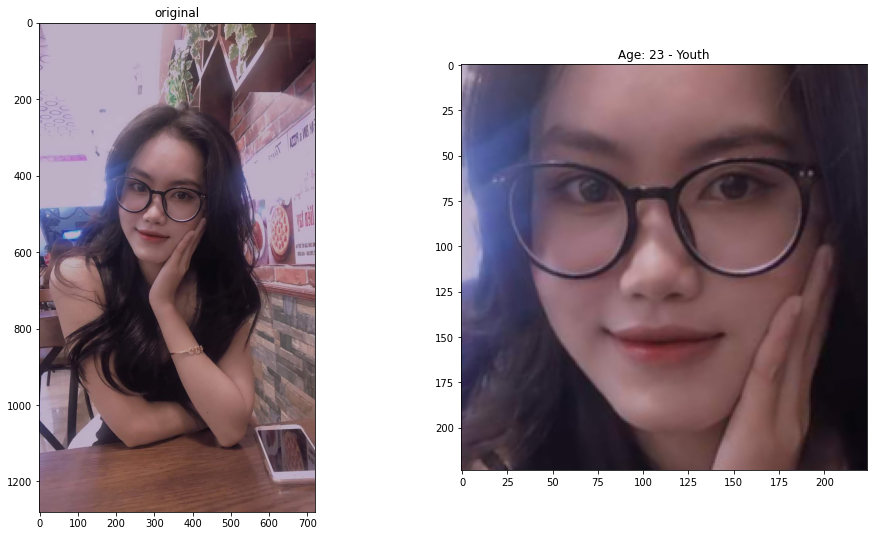

In [40]:
plt.figure(figsize=(16,9))

ax = plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(test_path))
plt.title('original')

ax = plt.subplot(1, 2, 2)
plt.imshow(detected_face)
plt.title(text)

# Deploys API

In [16]:
from flask import Flask
from flask_ngrok import run_with_ngrok
from flask_cors import CORS, cross_origin
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from deepface import DeepFace

app = Flask(__name__)
run_with_ngrok(app) # ngrok colab

model = load_model('/content/drive/MyDrive/FacialAge/Model_linear/MobileNetV3Large')

groups_names= ['Children', 'Teenage', 'Youth', 'Middle', 'Old']
img_path = '/content/drive/MyDrive/FacialAge/image.jpg' # data predict

def preprocess_image(data):
    image = Image.fromarray(data, 'RGB')
    image = image.resize((224,224))
    image = np.array(image)
    image = np.expand_dims(image, axis = 0)
    return image

def predict_class(age):
    if age <= 10: return groups_names[0] #Children 0 - 10
    if age <= 18: return groups_names[1] #Teenage 10 - 18
    if age <= 34: return groups_names[2] #Youth   19 - 34
    if age <= 60: return groups_names[3] #Middle  35 - 60
    return groups_names[4]               #Old     61+

def detect_face(img_path):
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']
    detected_face = DeepFace.detectFace( img_path , detector_backend=backends[2])
    return detected_face

def predict_age(image):
    input = preprocess_image(image)
    result = model.predict(input)
    return int(result), predict_class(result)

CORS(app)
app.config['CORS_HEADERS'] = 'Content-Type'

@app.route('/', methods=['POST','GET'])
@cross_origin(origin='*')
def process():
    image = detect_face(img_path)
    age, age_class = predict_age(image)
    tr = str(age) + ' - ' + str(age_class)
    return tr


if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://7e976ea04d5f.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [06/Jul/2021 19:11:33] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [06/Jul/2021 19:11:33] "GET /favicon.ico HTTP/1.1" 404 -
